Notebook objective: Train & tune GPBoost Booster + random effect model. Goal is to compare the Booster's learning with 2.0LGBM, and determine if it is training properly.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GroupKFold
import gpboost as gpb

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=6, edgeitems = 7)
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_columns', None)

## Preprocessing

In [32]:
random_state = 1923

In [33]:
# Read data
df = pd.read_csv("./OutputData/training_data.csv")

In [34]:
# Split features, groupings and target
X = df.drop(["life_expectancy", "country", "year"], axis = 1)
G = df[["country", "year"]]
y = df.life_expectancy

In [35]:
# Randomly select 25 countries for the testing set
rng = np.random.default_rng(random_state)
test_countries = rng.choice(G.country, size = 25)
test_countries

array(['Guyana', 'Serbia', 'Turkmenistan', 'Samoa', 'Poland',
       'Sao Tome and Principe', 'Latvia', 'Solomon Islands', 'Bhutan',
       'Armenia', 'Mauritania', 'Mozambique', 'Malawi',
       'Dominican Republic', 'Uganda', 'Madagascar', 'Sweden',
       'Central African Republic', 'Zimbabwe', 'Mongolia', 'El Salvador',
       'Argentina', 'Comoros', 'Israel', 'Angola'], dtype=object)

In [36]:
# Split train-test
G_test = G[G["country"].isin(test_countries)]
X_test = X[X.index.isin(G_test.index)]
y_test = y[G_test.index]

G = G[~G["country"].isin(test_countries)]
X = X[X.index.isin(G.index)]
y = y[G.index]
X = X.reset_index(drop = True)
G = G.reset_index(drop = True)
y = y.reset_index(drop = True)

In [14]:
# Create CV splitter
#cv = StratifiedKFold(n_splits = 3)
cv = GroupKFold(n_splits = 3)

## Hyperparameter tuning

In [15]:
# Objective function (Sklearn API)
def objective_gpb(trial):

    # Define hyperparameter space
    learning_rate = trial.suggest_float("learning_rate", 0.05, 0.5)
    num_leaves = trial.suggest_int("num_leaves", 2**2, 2**10)
    min_child_samples = trial.suggest_int("min_child_samples", 10, 1000, log = True)
    min_child_weight = trial.suggest_int("min_child_weight", 0.001, 20)
    reg_alpha = trial.suggest_float("l1_reg", 5e-5, 1, log = True)
    reg_lambda = trial.suggest_float("l2_reg", 0, 2)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.25, 1)

    # Store tuning scores & number of rounds
    scores = []
    rounds = []

    for i, (train_index, val_index) in enumerate(cv.split(X = X, groups = G["country"])):

        # Split train - val
        X_train, G_train, y_train = X.iloc[train_index, ], G.iloc[train_index, ], y[train_index]
        X_val, G_val, y_val = X.iloc[val_index, ], G.iloc[val_index, ], y[val_index]
    
        # Create model
        model = gpb.GPBoostRegressor(
        n_jobs = 10,
        #device_type = "gpu",
        n_estimators = 5000,
        num_leaves = num_leaves,
        random_state = random_state,
        max_depth = -1,
        min_child_samples = min_child_samples,
        learning_rate = learning_rate,
        min_child_weight = min_child_weight,
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda,
        colsample_bytree = colsample_bytree
        )

        # Create random effects model
        gp_model = gpb.GPModel(
            group_data = G_train, # Random intercepts for each group
            likelihood = "gaussian",
            seed = random_state
        )
        gp_model.set_prediction_data(group_data_pred = G_val)

        # Train model with early stopping
        model.fit(
            X_train, 
            y_train,
            gp_model = gp_model, 
            eval_set = [(X_val, y_val)],
            early_stopping_rounds = 50,
            verbose = False)

        # Record best number of rounds
        rounds.append(model.best_iteration_)

        # Record best score
        scores.append(model.best_score_['valid_0']['l2'])

    # Report mean number of rounds
    trial.set_user_attr("n_rounds", (np.mean(rounds)))
    
    return np.mean(scores)


In [16]:
# Create study
study_gpb = optuna.create_study(
  sampler = optuna.samplers.TPESampler(seed = random_state),
  study_name = "tune_gpb",
  direction = "minimize"
)

[I 2023-12-12 10:31:36,495] A new study created in memory with name: tune_gpb


In [17]:
# Perform study
optuna.logging.set_verbosity(optuna.logging.ERROR)
study_gpb.optimize(
  objective_gpb, 
  n_trials = 500,
  show_progress_bar = True)

Best trial: 216. Best value: 52.6126: 100%|██████████████████████████████████████████| 500/500 [12:04<00:00,  1.45s/it]


In [18]:
# Save tuning log
trials_gpb = study_gpb.trials_dataframe().sort_values("value", ascending = True)
trials_gpb.to_csv("./OutputData/trials_gpb.csv", index = False)

## Testing & diagnostics

In [19]:
# Load best 5 tunes
best_tunes = pd.read_csv("./OutputData/trials_gpb.csv")
best_tunes = best_tunes[best_tunes["state"] == "COMPLETE"].iloc[0:5]
best_tune = best_tunes.iloc[0]

In [20]:
best_tunes

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_l1_reg,params_l2_reg,params_learning_rate,params_min_child_samples,params_min_child_weight,params_num_leaves,params_subsample,user_attrs_n_rounds,state
0,216,52.612632,2023-12-12 10:36:39.107653,2023-12-12 10:36:41.489607,0 days 00:00:02.381954,0.678177,0.000762,0.444222,0.461601,147,9,362,0.569981,817.666667,COMPLETE
1,486,53.203020,2023-12-12 10:43:22.859053,2023-12-12 10:43:25.540278,0 days 00:00:02.681225,0.775909,0.071397,1.899708,0.399925,119,5,331,0.664456,697.000000,COMPLETE
2,360,53.967874,2023-12-12 10:40:18.664457,2023-12-12 10:40:21.027704,0 days 00:00:02.363247,0.586333,0.082816,1.036780,0.385030,142,8,414,0.555844,901.000000,COMPLETE
3,223,54.273817,2023-12-12 10:36:52.527238,2023-12-12 10:36:55.117089,0 days 00:00:02.589851,0.708035,0.000838,0.220435,0.320012,148,9,304,0.620099,1134.666667,COMPLETE
4,217,54.422709,2023-12-12 10:36:41.491106,2023-12-12 10:36:43.736499,0 days 00:00:02.245393,0.721996,0.000538,0.131871,0.441095,138,9,340,0.570928,704.333333,COMPLETE


In [37]:
# Preprocess data for final model
X_train = X.copy()
y_train = y.copy()
G_train = G.copy()

train = gpb.Dataset(X_train, y_train)
test = gpb.Dataset(X_test, y_test)

In [45]:
# Create random effects model
gp_model = gpb.GPModel(
        group_data = G_train,
        likelihood = "gaussian",
        seed = random_state
    )

In [46]:
# Create params dict
params = {
    "random_state": random_state,
    "n_estimators": int(best_tune["user_attrs_n_rounds"]),
    "num_leaves": best_tune["params_num_leaves"],
    "min_child_samples": best_tune["params_min_child_samples"],
    "learning_rate": best_tune["params_learning_rate"],
    "min_child_weight": best_tune["params_min_child_weight"],
    "reg_alpha": best_tune["params_l1_reg"],
    "reg_lambda": best_tune["params_l2_reg"],
    "colsample_bytree": best_tune["params_colsample_bytree"]
}

In [47]:
# Train booster
model = gpb.train(
    params = params,
    train_set = train,
    gp_model = gp_model
)

Found `n_estimators` in params. Will use it instead of argument


[GPBoost] [Info] Total Bins 2665
[GPBoost] [Info] Number of data points in the train set: 1328, number of used features: 16
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=70.044578
[GPBoost] [Info] Start training from score 70.044578


In [48]:
# Make predictions on test data
preds = model.predict(
    X_test, 
    group_data_pred = G_test, 
    predict_var = True, pred_latent = True)

In [49]:
# Get predictions
preds_fixed = preds['fixed_effect']
preds_random = preds["random_effect_mean"]
preds_total = preds_fixed + preds_random

In [50]:
# Calculate MSE, RMSE, MAPE
print("MSE:")
print(round(mean_squared_error(y_test, preds_total), 4))

print("RMSE:")
print(round(mean_squared_error(y_test, preds_total, squared = False), 4))

print("MAPE:")
print(round(mean_absolute_percentage_error(y_test, preds_total), 4))

MSE:
79.9589
RMSE:
8.942
MAPE:
0.1204


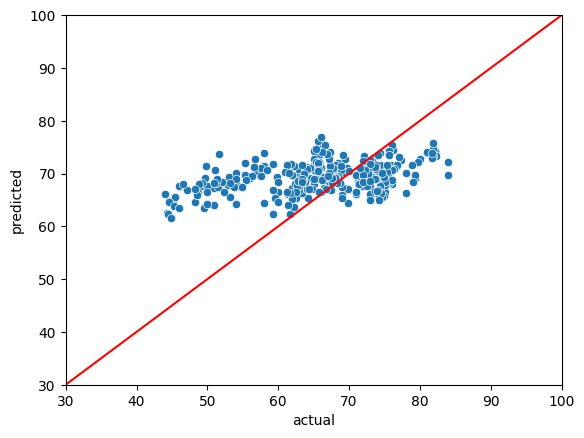

In [51]:
# Plot predicted vs. actual
_ = sns.scatterplot(x = y_test,  y = preds_total)
_ = plt.plot([30, 100], [30, 100], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(30, 100)
_ = plt.xlabel("actual")
_ = plt.ylabel("predicted")

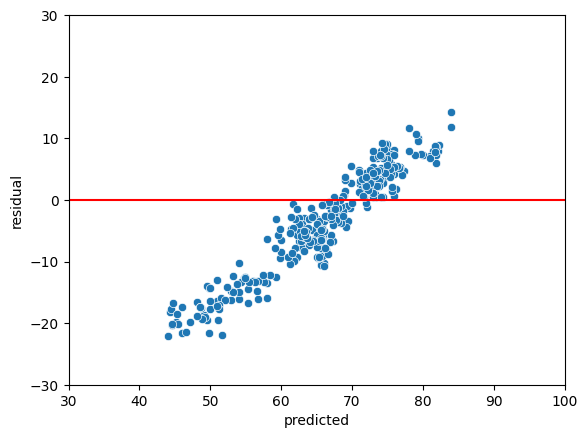

In [54]:
# Predicted vs residual
resids = y_test - preds_total
_ = sns.scatterplot(x = y_test, y= resids)
_ = plt.plot([30, 100], [0, 0], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(-30, 30)
_ = plt.xlabel("predicted")
_ = plt.ylabel("residual")

The predictions are fairly constant compared to LGBM.

## Inference

In [55]:
# Get SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

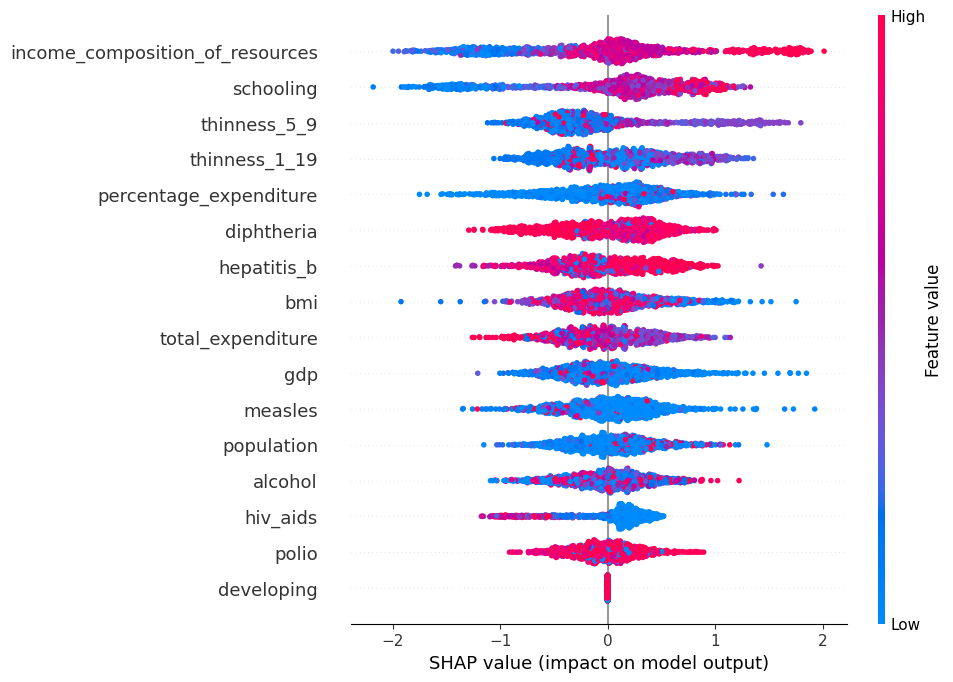

In [56]:
# SHAP summary of all features
shap.plots.beeswarm(shap_values, max_display = 20)

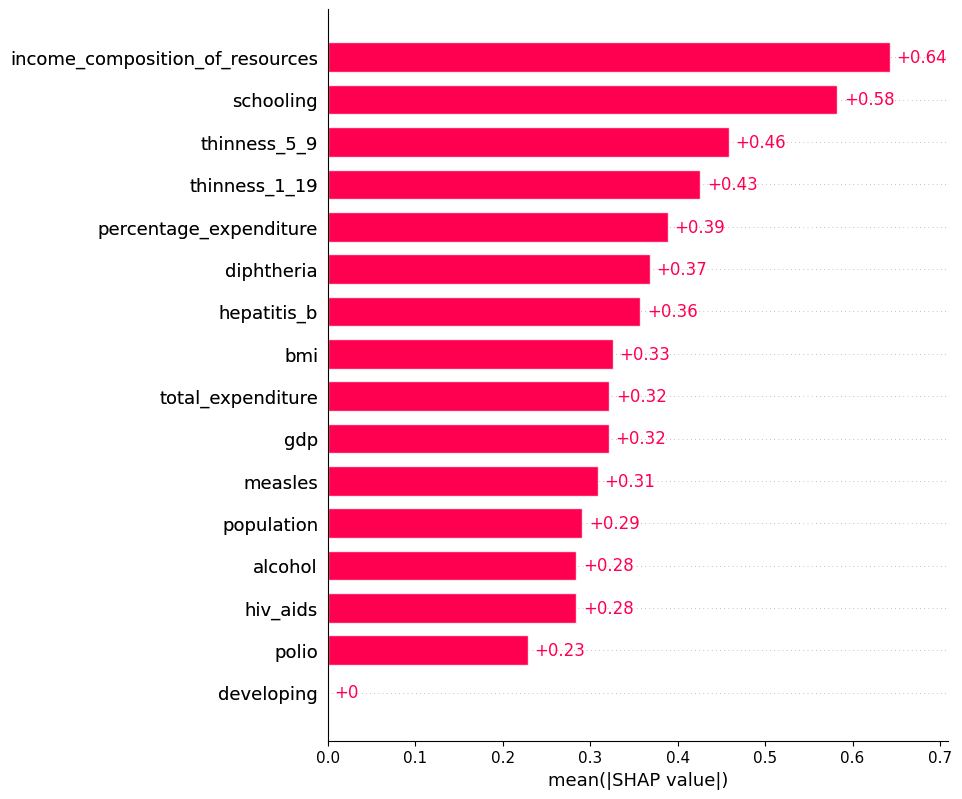

In [57]:
shap.plots.bar(shap_values, max_display = 20)

Without target encoded country information as a predictor, fixed predictors have much less impact on the prediction. Few of them are discriminatory.

In [64]:
# Retrieve & plot average contribution of random effects to predictions for each group
random_effects = G_test.copy()
random_effects["random_effect"] = preds_random
random_effects_country = random_effects.groupby("country").random_effect.mean().sort_values(ascending = False)
random_effects_year = random_effects.groupby("year").random_effect.mean()

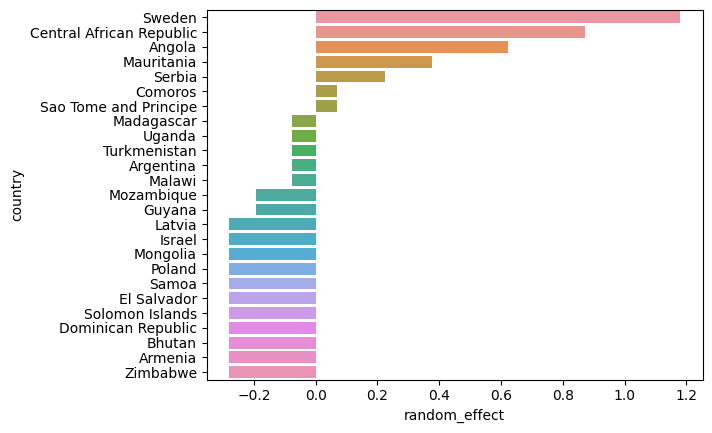

In [65]:
# Countries
_ = sns.barplot(x = random_effects_country, y = random_effects_country.index)

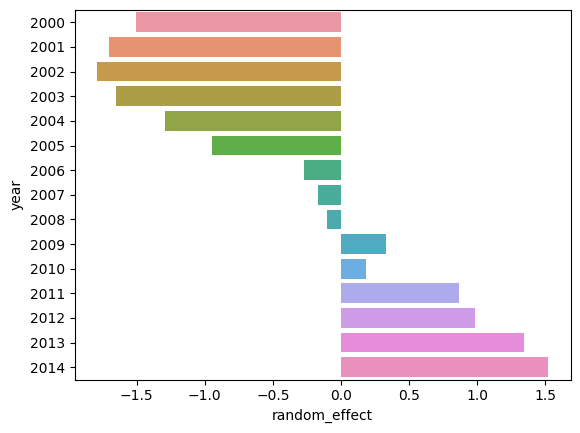

In [66]:
# Years
_ = sns.barplot(x = random_effects_year, y = random_effects_year.index.astype(str))

The random effects appear to be a bit more significant compared to the previous testing scheme. The year ordering makes sense.